In [212]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from string_to_embedding import string_to_embedding, super_to_embedding

In [213]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)

        # First fully connected layer
        #self.fc1 = nn.Linear(zdim, ldim)
        # Second fully connected layer that outputs our 10 labels
        
        ldim = zdim*imgshape[0]*imgshape[1]
        outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(ldim, outdim)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(x)
        print(x.shape)
        
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        print(x.shape)
        
        #x = self.fc1(x)
        #x = F.sigmoid(x)
        #print(x.shape)
        #x = self.dropout2(x)
        x = self.fc2(x)
        print(x.shape)
        
        x = F.relu(x, 1) 
        #x = torch.bool(x)
        return x

model = Model()
print(model)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=288, out_features=243, bias=True)
)


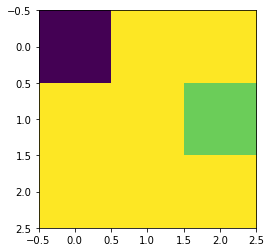

In [214]:
rand_smap = generate_gaussian(10, 3, 3)
plt.imshow(rand_smap)

In [215]:
rand_smap = torch.Tensor(rand_smap.reshape(1, 1, rand_smap.shape[0], rand_smap.shape[1]))
print(rand_smap)

tensor([[[[ 0.0000, 10.0000, 10.0000],
          [10.0000, 10.0000,  7.7586],
          [10.0000, 10.0000, 10.0000]]]])


In [217]:
result = model(rand_smap)
print(result)
print(result.shape)

torch.Size([1, 8, 3, 3])
torch.Size([1, 32, 3, 3])
torch.Size([1, 288])
torch.Size([1, 243])
tensor([[3.1990e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0551e-01, 5.1601e-01,
         0.0000e+00, 1.1015e+00, 0.0000e+00, 1.0922e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.6377e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.9118e-01, 0.0000e+00, 0.0000e+00, 3.4749e-01,
         1.0720e-01, 3.5403e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7233e-01,
         7.1943e-01, 4.9259e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.4520e-01,
         0.0000e+00, 1.1314e+00, 5.8017e-01, 0.0000e+00, 1.1342e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 6.5748e-01, 0.0000e+00, 0.0000e+00, 1.9361e-01,
         0.0000e+00, 3.5817e-01, 0.0000e+00, 4.5273e-02, 0.0000e+00, 2.5902e-01,
         4.9752e-01, 3.1498e-01, 1.2514e+00, 1.3888e-01, 0.0000e+00, 5.5972e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0306e-01, 0.0000e+00, 0.0000e+00,
         0.0000e

In [218]:
## convert output to embedding using SolarModule object
model.eval()
with torch.no_grad():
    out_data = model(rand_smap)
    out_data = out_data.type(torch.bool)
    print(out_data)
    
    embedding = out_data.reshape(3, 3, 3, 3, 3).cpu().numpy()
    
moduleobj = SolarModule(3,3)
moduleobj.embedding = embedding
moduleobj.filter_embedding()
moduleobj.make_netlist()


torch.Size([1, 8, 3, 3])
torch.Size([1, 32, 3, 3])
torch.Size([1, 288])
torch.Size([1, 243])
tensor([[ True, False, False, False,  True,  True, False,  True, False,  True,
         False, False, False, False,  True, False, False, False, False, False,
          True, False, False,  True,  True,  True, False, False, False,  True,
          True,  True, False, False, False,  True, False,  True,  True, False,
          True, False, False, False,  True, False, False,  True, False,  True,
         False,  True, False,  True,  True,  True,  True,  True, False,  True,
         False, False, False,  True, False, False, False,  True,  True, False,
          True, False,  True,  True, False,  True, False,  True,  True,  True,
          True, False,  True, False, False,  True, False, False,  True, False,
          True, False, False, False, False, False, False,  True, False, False,
         False, False,  True, False,  True,  True,  True,  True, False, False,
          True,  True, False, False, F

ValueError: Invalid embedding.